# Why A_2 and p_4 Have Different Null Distributions

Both A_2 and p_4 have Broderick values close to zero, yet their null (permutation) distributions look very different:
- **A_2**: null distribution peaks around 1 → actual error at ~70th percentile (not significant)
- **p_4**: null distribution peaks around 10³ → actual error at ~17th percentile (significant)

This notebook shows **why** using a simple toy example — no real data needed.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Step 1: What is a gradient?

Think of the **loss function** as a landscape of hills and valleys. The optimizer's job is to find the lowest valley (minimum loss). The **gradient** tells it:

1. **Which direction** to move each parameter (uphill or downhill?)
2. **How much** to move (steep slope = big step, flat = tiny step)

**Key rule: if a parameter's gradient ≈ 0, the optimizer barely moves it.**

### Toy example

Say our loss is $L = (x - 3)^2$. The minimum is at $x = 3$.

The gradient (derivative) is $dL/dx = 2(x - 3)$.
- At $x = 0$: gradient = $-6$ → move $x$ in the positive direction (toward 3)
- At $x = 3$: gradient = $0$ → stop, we're at the minimum
- At $x = 5$: gradient = $+4$ → move $x$ in the negative direction (back toward 3)

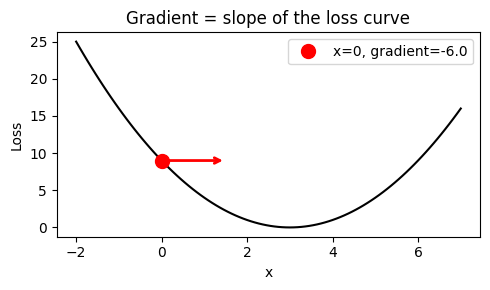

In [2]:
# PyTorch computes gradients automatically with .backward()
x = torch.tensor(0.0, requires_grad=True)  # start at x=0
loss = (x - 3) ** 2                         # loss = (0-3)^2 = 9
loss.backward()                              # compute dL/dx

x_vals = np.linspace(-2, 7, 100)
loss_vals = (x_vals - 3) ** 2

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(x_vals, loss_vals, 'k-')
ax.plot(0, 9, 'ro', markersize=10, label=f'x=0, gradient={x.grad.item():.1f}')
ax.annotate('', xy=(1.5, 9), xytext=(0, 9),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax.set_xlabel('x'), ax.set_ylabel('Loss')
ax.set_title('Gradient = slope of the loss curve')
ax.legend()
plt.tight_layout()

## Step 2: How A_2 and p_4 enter the model differently

The 2D model predicts BOLD response as:

$$\text{pred} = A_v \cdot \exp\!\left(-\frac{(\log_2 \omega_l + \log_2 P_v)^2}{2\sigma^2}\right)$$

Where:
- $A_v = 1 + A_1 \cos(2\theta_l) + \mathbf{A_2} \cos(4\theta_l) + \ldots$ → **scales the height** of the curve
- $P_v = (\text{slope} \cdot r + \text{intercept})(1 + p_1 \cos(2\theta_l) + \ldots + \mathbf{p_4} \cos(4(\theta_l - \theta_v)))$ → **shifts the peak location** of the curve

Let's build this with synthetic data.

In [3]:
# Create synthetic stimulus conditions (20 stimuli)
np.random.seed(42)
n_stim = 20
theta_l = torch.tensor(np.random.uniform(0, 2*np.pi, n_stim), dtype=torch.float32)
theta_v = torch.tensor(np.random.uniform(0, 2*np.pi, n_stim), dtype=torch.float32)
r_v = torch.tensor(np.random.uniform(1, 5, n_stim), dtype=torch.float32)
w_l = torch.tensor(np.random.uniform(0.5, 8, n_stim), dtype=torch.float32)

def make_params():
    """Create fresh parameter tensors (need new ones each time for clean gradients)."""
    return {
        'sigma': torch.tensor(2.0, requires_grad=True),
        'slope': torch.tensor(0.12, requires_grad=True),
        'intercept': torch.tensor(0.2, requires_grad=True),
        'p_1': torch.tensor(0.05, requires_grad=True),
        'p_2': torch.tensor(-0.03, requires_grad=True),
        'p_3': torch.tensor(0.04, requires_grad=True),
        'p_4': torch.tensor(0.01, requires_grad=True),
        'A_1': torch.tensor(0.04, requires_grad=True),
        'A_2': torch.tensor(0.01, requires_grad=True),
    }

def compute_pred(sigma, slope, intercept, p_1, p_2, p_3, p_4, A_1, A_2):
    """Forward pass of the 2D model."""
    Av = 1 + A_1 * torch.cos(2*theta_l) + A_2 * torch.cos(4*theta_l)
    Av = torch.clamp(Av, min=1e-6)
    ecc = slope * r_v + intercept
    Pv = ecc * (1 + p_1*torch.cos(2*theta_l) + p_2*torch.cos(4*theta_l)
               + p_3*torch.cos(2*(theta_l - theta_v)) + p_4*torch.cos(4*(theta_l - theta_v)))
    Pv = torch.clamp(Pv, min=1e-6)
    return Av * torch.exp(-(torch.log2(w_l) + torch.log2(Pv))**2 / (2 * sigma**2))

## Step 3: L2 normalization erases what A_2 does

The loss function **L2-normalizes** predictions before comparing to data:
$$\text{norm\_pred} = \frac{\text{pred}}{\|\text{pred}\|_2}$$

This divides out the overall scale. Since A_2 lives in $A_v$ (a multiplier on the whole prediction), its effect gets divided away.

Let's see this: perturb A_2 vs p_4 by the same amount and check how much the **normalized** output changes.

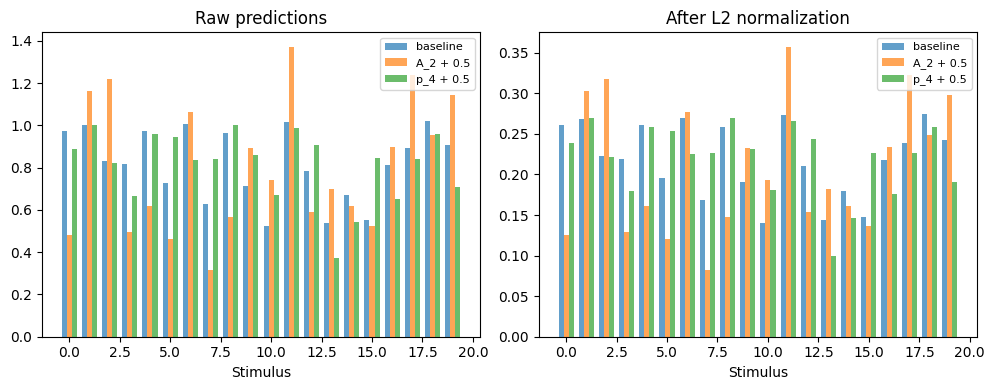

In [4]:
def l2_normalize(x):
    return x / torch.linalg.norm(x)

params = make_params()

# Baseline
pred_base = compute_pred(**params).detach()
norm_base = l2_normalize(pred_base)

# Perturb A_2 by +0.5
params_A2 = make_params()
params_A2['A_2'] = torch.tensor(0.51, requires_grad=True)
pred_A2 = compute_pred(**params_A2).detach()
norm_A2 = l2_normalize(pred_A2)

# Perturb p_4 by +0.5
params_p4 = make_params()
params_p4['p_4'] = torch.tensor(0.51, requires_grad=True)
pred_p4 = compute_pred(**params_p4).detach()
norm_p4 = l2_normalize(pred_p4)

change_A2_raw = torch.mean((pred_A2 - pred_base)**2).item()
change_p4_raw = torch.mean((pred_p4 - pred_base)**2).item()
change_A2_norm = torch.mean((norm_A2 - norm_base)**2).item()
change_p4_norm = torch.mean((norm_p4 - norm_base)**2).item()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
x = np.arange(n_stim)

axes[0].bar(x - 0.25, pred_base.numpy(), 0.25, label='baseline', alpha=0.7)
axes[0].bar(x, pred_A2.numpy(), 0.25, label='A_2 + 0.5', alpha=0.7)
axes[0].bar(x + 0.25, pred_p4.numpy(), 0.25, label='p_4 + 0.5', alpha=0.7)
axes[0].set_title(f'Raw predictions')
axes[0].set_xlabel('Stimulus')
axes[0].legend(fontsize=8)

axes[1].bar(x - 0.25, norm_base.numpy(), 0.25, label='baseline', alpha=0.7)
axes[1].bar(x, norm_A2.numpy(), 0.25, label='A_2 + 0.5', alpha=0.7)
axes[1].bar(x + 0.25, norm_p4.numpy(), 0.25, label='p_4 + 0.5', alpha=0.7)
axes[1].set_title(f'After L2 normalization')
axes[1].set_xlabel('Stimulus')
axes[1].legend(fontsize=8)

plt.tight_layout()

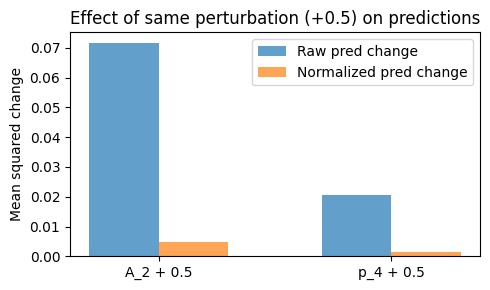

In [5]:
fig, ax = plt.subplots(figsize=(5, 3))
labels = ['A_2 + 0.5', 'p_4 + 0.5']
x_pos = np.arange(2)
ax.bar(x_pos - 0.15, [change_A2_raw, change_p4_raw], 0.3, label='Raw pred change', alpha=0.7)
ax.bar(x_pos + 0.15, [change_A2_norm, change_p4_norm], 0.3, label='Normalized pred change', alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylabel('Mean squared change')
ax.set_title('Effect of same perturbation (+0.5) on predictions')
ax.legend()
plt.tight_layout()

## Step 4: Compare gradients — the smoking gun

Now let's compute **actual gradients** from the loss function.

Remember: the gradient tells the optimizer how much to move each parameter. If a gradient is tiny, the parameter barely moves during training.

We compare:
1. **With L2 normalization** (our actual loss) → expect A_2 gradient to be tiny
2. **Without L2 normalization** → expect gradients to be more comparable

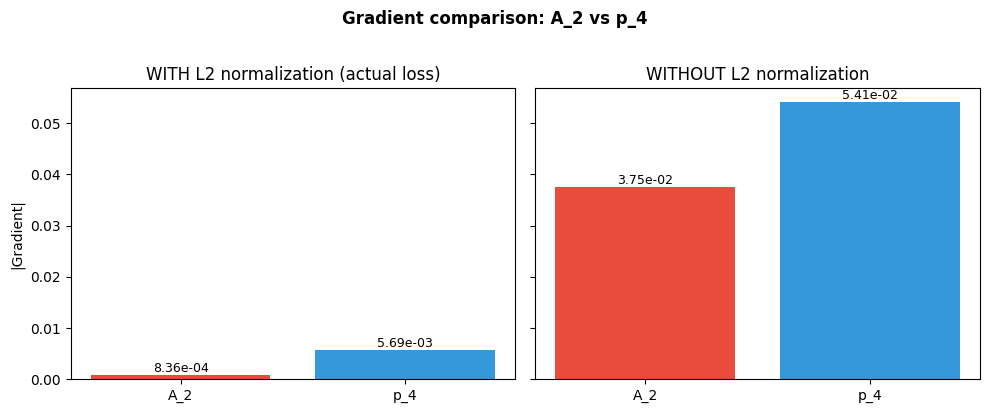

In [6]:
# Random target (simulates null/shuffled data)
torch.manual_seed(0)
target = torch.rand(n_stim)

# --- WITH L2 normalization (actual loss) ---
params = make_params()
pred = compute_pred(**params)
norm_pred = pred / torch.linalg.norm(pred)
norm_target = target / torch.linalg.norm(target)
loss_normed = torch.mean((norm_pred - norm_target)**2)
loss_normed.backward()
grad_with_norm = {k: abs(v.grad.item()) for k, v in params.items()}

# --- WITHOUT L2 normalization ---
params2 = make_params()
pred2 = compute_pred(**params2)
loss_raw = torch.mean((pred2 - target)**2)
loss_raw.backward()
grad_without_norm = {k: abs(v.grad.item()) for k, v in params2.items()}

# Plot A_2 vs p_4
focus = ['A_2', 'p_4']
x_pos = np.arange(len(focus))

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].bar(x_pos, [grad_with_norm[p] for p in focus], color=['#e74c3c', '#3498db'])
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(focus)
axes[0].set_ylabel('|Gradient|')
axes[0].set_title('WITH L2 normalization (actual loss)')
for i, p in enumerate(focus):
    axes[0].text(i, grad_with_norm[p], f'{grad_with_norm[p]:.2e}', ha='center', va='bottom', fontsize=9)

axes[1].bar(x_pos, [grad_without_norm[p] for p in focus], color=['#e74c3c', '#3498db'])
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(focus)
axes[1].set_title('WITHOUT L2 normalization')
for i, p in enumerate(focus):
    axes[1].text(i, grad_without_norm[p], f'{grad_without_norm[p]:.2e}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Gradient comparison: A_2 vs p_4', fontweight='bold', y=1.02)
plt.tight_layout()

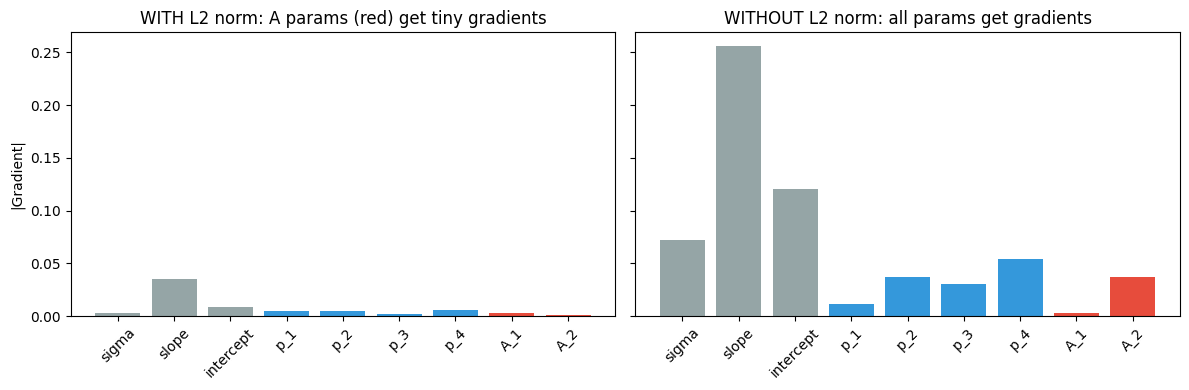

In [7]:
# All parameters
all_params = list(make_params().keys())
x_pos = np.arange(len(all_params))
colors = ['#e74c3c' if 'A_' in p else '#3498db' if 'p_' in p else '#95a5a6' for p in all_params]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].bar(x_pos, [grad_with_norm[p] for p in all_params], color=colors)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(all_params, rotation=45)
axes[0].set_ylabel('|Gradient|')
axes[0].set_title('WITH L2 norm: A params (red) get tiny gradients')

axes[1].bar(x_pos, [grad_without_norm[p] for p in all_params], color=colors)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(all_params, rotation=45)
axes[1].set_title('WITHOUT L2 norm: all params get gradients')

plt.tight_layout()

## Step 5: Simulate null model fitting

Now let's run the optimizer for many steps on **random target data** (like a permutation test).

We track how A_2 and p_4 move over training epochs.

Prediction: **A_2 stays near its starting value, p_4 drifts away.**

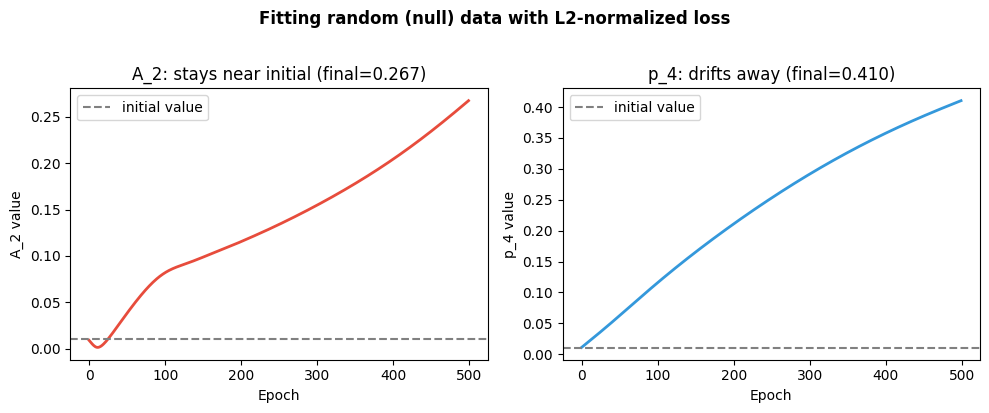

In [8]:
params = make_params()
optimizer = torch.optim.Adam(params.values(), lr=1e-3)

torch.manual_seed(7)
target = torch.rand(n_stim)

n_epochs = 500
history = {k: [] for k in params}

for epoch in range(n_epochs):
    optimizer.zero_grad()
    pred = compute_pred(**params)
    norm_pred = pred / torch.linalg.norm(pred)
    norm_target = target / torch.linalg.norm(target)
    loss = torch.mean((norm_pred - norm_target)**2)
    loss.backward()
    optimizer.step()
    for k, v in params.items():
        history[k].append(v.item())

# A_2 vs p_4 trajectories
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(history['A_2'], color='#e74c3c', lw=2)
axes[0].axhline(0.01, color='gray', ls='--', label='initial value')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('A_2 value')
axes[0].set_title(f'A_2: stays near initial (final={history["A_2"][-1]:.3f})')
axes[0].legend()

axes[1].plot(history['p_4'], color='#3498db', lw=2)
axes[1].axhline(0.01, color='gray', ls='--', label='initial value')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('p_4 value')
axes[1].set_title(f'p_4: drifts away (final={history["p_4"][-1]:.3f})')
axes[1].legend()

plt.suptitle('Fitting random (null) data with L2-normalized loss', fontweight='bold', y=1.02)
plt.tight_layout()

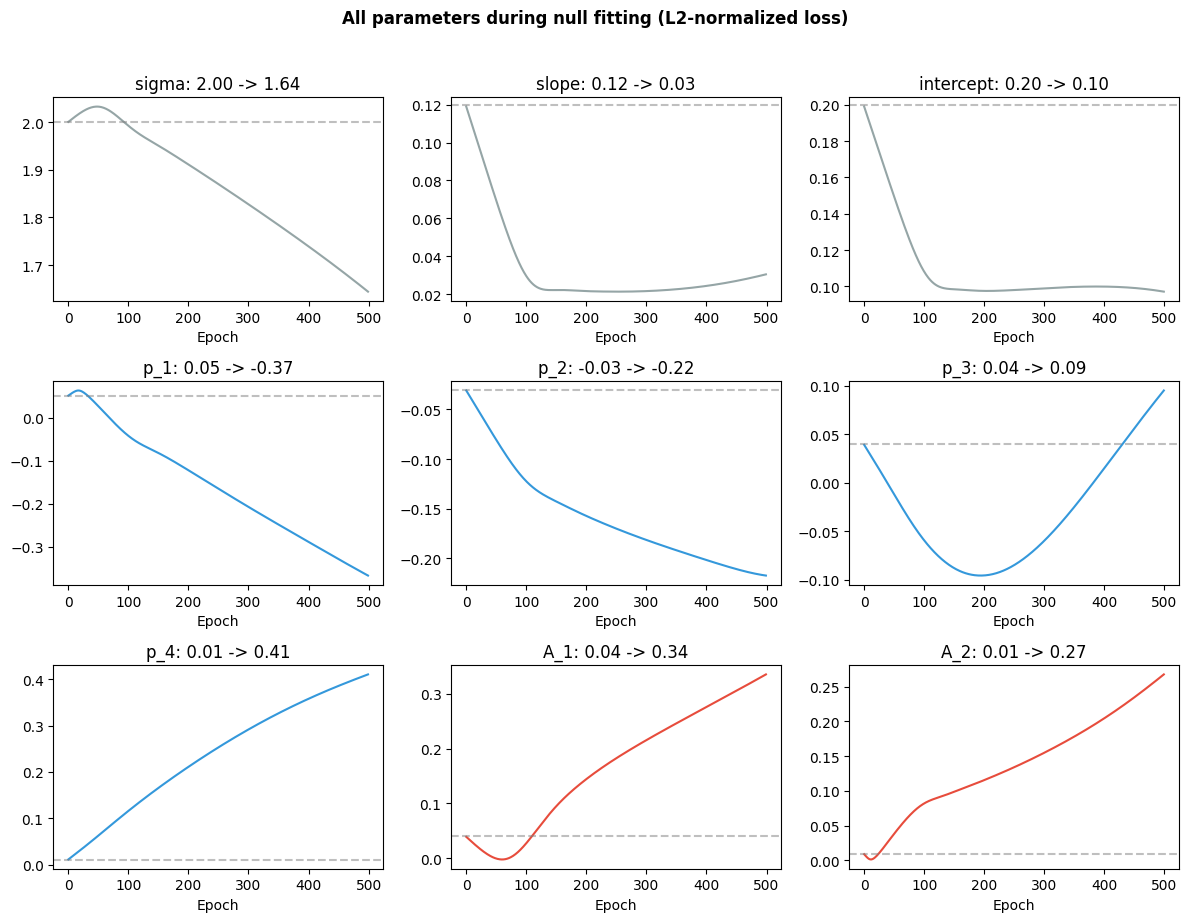

In [9]:
# All parameters
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

init_vals = make_params()
for ax, param in zip(axes.flatten(), all_params):
    color = '#e74c3c' if 'A_' in param else '#3498db' if 'p_' in param else '#95a5a6'
    ax.plot(history[param], color=color, lw=1.5)
    ax.axhline(init_vals[param].item(), color='gray', ls='--', alpha=0.5)
    ax.set_title(f'{param}: {init_vals[param].item():.2f} -> {history[param][-1]:.2f}')
    ax.set_xlabel('Epoch')

plt.suptitle('All parameters during null fitting (L2-normalized loss)', fontweight='bold', y=1.02)
plt.tight_layout()

## Summary

| | A_2 (amplitude) | p_4 (frequency preference) |
|---|---|---|
| **Role** | Scales prediction height ($A_v$) | Shifts peak location ($P_v$, via $\log_2$) |
| **Effect of L2 norm** | Divided away (scale doesn't matter) | Preserved (shape matters) |
| **Gradient size** | Tiny → optimizer barely moves it | Meaningful → optimizer moves it |
| **Under null data** | Stays near 0 (initialization) | Drifts to large values |
| **Standardized error** | Small (~1) | Huge (~10³) |

**Bottom line**: L2 normalization makes the loss function blind to amplitude modulation (A_2), so A_2 gets stuck near zero regardless of the data. p_4 affects curve *shape*, which the normalized loss can still see, so the optimizer pushes it to large values when fitting noise.